In [1]:
from models.iforest import IsolationForest
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
from util.utils import find_TPR_threshold
from sklearn.ensemble import IsolationForest as skIsolationForest
import time
import os

In [2]:
# Load data
filenames = os.listdir('../datasets/CIC-IDS-17')
datasets = []
for filename in filenames:
    data = pd.read_csv(f'../datasets/CIC-IDS-17/{filename}')
    X = data.drop(' Label', axis=1)
    y = pd.Series([0 if x == 'BENIGN' else 1 for x in data[' Label']])
    datasets.append((X, y, filename))

    print(f'Dataset: {filename}')
    print(f'Dataset shape: {X.shape}')
    print(f'Benign samples: {y.value_counts()[0]}')
    print(f'Anomalies in dataset: {y.value_counts().get(1, 0)}')
    print(f'Contamination rate: {y.value_counts().get(1, 0) / y.count() * 100:.4f} %\n')

complete_dataset = (pd.concat([x[0] for x in datasets]), pd.concat([x[1] for x in datasets]))
print(f'Complete dataset shape: {complete_dataset[0].shape}')
print(f'Benign samples: {complete_dataset[1].value_counts()[0]}')
print(f'Anomalies in dataset: {complete_dataset[1].value_counts().get(1, 0)}')
print(f'Contamination rate: {complete_dataset[1].value_counts().get(1, 0) / complete_dataset[1].count() * 100:.4f} %\n')

Dataset: Wednesday-workingHours.pcap_ISCX.csv
Dataset shape: (692703, 78)
Benign samples: 440031
Anomalies in dataset: 252672
Contamination rate: 36.4762 %

Dataset: Monday-WorkingHours.pcap_ISCX.csv
Dataset shape: (529919, 78)
Benign samples: 529918
Anomalies in dataset: 1
Contamination rate: 0.0002 %

Dataset: Tuesday-WorkingHours.pcap_ISCX.csv
Dataset shape: (445909, 78)
Benign samples: 432074
Anomalies in dataset: 13835
Contamination rate: 3.1027 %

Dataset: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Dataset shape: (286467, 78)
Benign samples: 127537
Anomalies in dataset: 158930
Contamination rate: 55.4793 %

Dataset: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Dataset shape: (225745, 78)
Benign samples: 97718
Anomalies in dataset: 128027
Contamination rate: 56.7131 %

Dataset: Friday-WorkingHours-Morning.pcap_ISCX.csv
Dataset shape: (191033, 78)
Benign samples: 189067
Anomalies in dataset: 1966
Contamination rate: 1.0291 %

Dataset: Thursday-WorkingHours-Afternoon-I

In [3]:
# Train Isolation Forest
clf_forests = []
sample_size = 200
n_trees = 300
for X, y, filename in datasets:
    print(f'Training Isolation Forest on {filename}')
    clf = IsolationForest(sample_size, n_trees)
    start_time = time.time()
    clf.fit(X, improved=False)
    clf_forests.append((clf, filename))
    end_time = time.time()
    print(f'{sample_size=}, {n_trees=}, training time: {end_time - start_time:.3f}s\n')

Training Isolation Forest on Wednesday-workingHours.pcap_ISCX.csv
sample_size=200, n_trees=300, training time: 0.826s

Training Isolation Forest on Monday-WorkingHours.pcap_ISCX.csv
sample_size=200, n_trees=300, training time: 0.342s

Training Isolation Forest on Tuesday-WorkingHours.pcap_ISCX.csv
sample_size=200, n_trees=300, training time: 0.212s

Training Isolation Forest on Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
sample_size=200, n_trees=300, training time: 0.239s

Training Isolation Forest on Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
sample_size=200, n_trees=300, training time: 0.181s

Training Isolation Forest on Friday-WorkingHours-Morning.pcap_ISCX.csv
sample_size=200, n_trees=300, training time: 0.184s

Training Isolation Forest on Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
sample_size=200, n_trees=300, training time: 0.204s

Training Isolation Forest on Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
sample_size=200, n_trees=300, tr

Predicting on Wednesday-workingHours.pcap_ISCX.csv
Dataset shape: (692703, 78)
Benign samples: 440031
Anomalies in dataset: 252672
Contamination rate: 36.4762 %

Prediction time: 657.041s
Predictions: 
1    491384
0    201319
Name: count, dtype: int64
[[184549 255482]
 [ 16770 235902]]
              precision    recall  f1-score   support

           0       0.92      0.42      0.58    440031
           1       0.48      0.93      0.63    252672

    accuracy                           0.61    692703
   macro avg       0.70      0.68      0.60    692703
weighted avg       0.76      0.61      0.60    692703

ROC AUC: 0.6765
F1 Score: 0.6341
Threshold: 0.7260

Predicting on Monday-WorkingHours.pcap_ISCX.csv
Dataset shape: (529919, 78)
Benign samples: 529918
Anomalies in dataset: 1
Contamination rate: 0.0002 %

Prediction time: 504.589s
Predictions: 
0    312431
1    217488
Name: count, dtype: int64
[[312431 217487]
 [     0      1]]
              precision    recall  f1-score   support

 

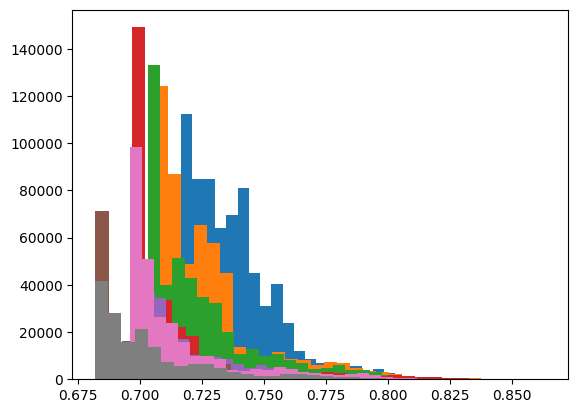

In [4]:
import matplotlib.pyplot as plt

for (clf, filename), (X, y, _) in zip(clf_forests, datasets):
    print(f'Predicting on {filename}')
    print(f'Dataset shape: {X.shape}')
    print(f'Benign samples: {y.value_counts()[0]}')
    print(f'Anomalies in dataset: {y.value_counts().get(1, 0)}')
    print(f'Contamination rate: {y.value_counts().get(1, 0) / y.count() * 100:.4f} %\n')
    
    # Predict
    start_time = time.time()
    scores = clf.anomaly_score(X)
    threshold, FPR = find_TPR_threshold(y, scores, 0.9)
    y_pred = clf.predict_from_anomaly_scores(scores, threshold)
    end_time = time.time()
    
    # Metrics
    plt.hist(scores, bins=30, label=f'{filename}')
    print(f'Prediction time: {end_time - start_time:.3f}s')
    print('Predictions: ')
    print(pd.Series(y_pred).value_counts())
    print(confusion_matrix(y, y_pred))
    print(classification_report(y, y_pred))
    print(f'ROC AUC: {roc_auc_score(y, y_pred):.4f}')
    print(f'F1 Score: {f1_score(y, y_pred):.4f}')
    print(f'Threshold: {threshold:.4f}\n')

Training on complete dataset
Dataset shape: (2830744, 78)
Benign samples: 2273097
Anomalies in dataset: 557647
Contamination rate: 19.6997 %

sample_size=200, n_trees=300, training time: 8.541s

Predicting on complete dataset
Prediction time: 2658.915s
Predictions: 
1    1984251
0     846493
Name: count, dtype: int64
[[ 835472 1437625]
 [  11021  546626]]
              precision    recall  f1-score   support

           0       0.99      0.37      0.54   2273097
           1       0.28      0.98      0.43    557647

    accuracy                           0.49   2830744
   macro avg       0.63      0.67      0.48   2830744
weighted avg       0.85      0.49      0.51   2830744

ROC AUC: 0.6739
F1 Score: 0.4301
Threshold: 0.7420



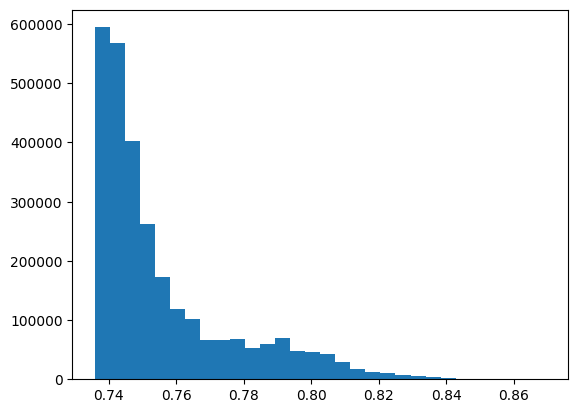

In [6]:
print('Training on complete dataset')
print(f'Dataset shape: {complete_dataset[0].shape}')
print(f'Benign samples: {complete_dataset[1].value_counts()[0]}')
print(f'Anomalies in dataset: {complete_dataset[1].value_counts().get(1, 0)}')
print(f'Contamination rate: {complete_dataset[1].value_counts().get(1, 0) / complete_dataset[1].count() * 100:.4f} %\n')

# Train Isolation Forest
clf_complete = IsolationForest(sample_size, n_trees)
start_time = time.time()
clf_complete.fit(complete_dataset[0], improved=False)
end_time = time.time()
print(f'{sample_size=}, {n_trees=}, training time: {end_time - start_time:.3f}s\n')

print('Predicting on complete dataset')
start_time = time.time()
scores = clf_complete.anomaly_score(complete_dataset[0])
threshold, FPR = find_TPR_threshold(complete_dataset[1], scores, 0.9)
y_pred = clf_complete.predict_from_anomaly_scores(scores, threshold)
end_time = time.time()

# Metrics
plt.hist(scores, bins=30, label='Complete dataset')
print(f'Prediction time: {end_time - start_time:.3f}s')
print('Predictions: ')
print(pd.Series(y_pred).value_counts())
print(confusion_matrix(complete_dataset[1], y_pred))
print(classification_report(complete_dataset[1], y_pred))
print(f'ROC AUC: {roc_auc_score(complete_dataset[1], y_pred):.4f}')
print(f'F1 Score: {f1_score(complete_dataset[1], y_pred):.4f}')
print(f'Threshold: {threshold:.4f}\n')

In [ ]:
# Compare with sklearn
sk_clf = skIsolationForest(contamination=0.2, n_estimators=100, max_samples=256, n_jobs=-1, random_state=42)
start_time = time.time()
sk_clf.fit(X)
end_time = time.time()
print(f'Sklearn training time: {end_time - start_time}')

ValueError: Input X contains NaN.
IsolationForest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Predict
sk_scores = sk_clf.decision_function(X).reshape(-1, 1)
sk_threshold, sk_FPR = find_TPR_threshold(y, sk_scores, 0.8)
sk_y_pred = [1 if score >= sk_threshold else 0 for score in sk_scores]

print(f'Confusion matrix: {confusion_matrix(y, sk_y_pred)}')
print(f'Classification report: {classification_report(y, sk_y_pred)}')
print(f'ROC AUC score: {roc_auc_score(y, sk_y_pred)}')
print(f'Threshold: {sk_threshold}')
print(f'FPR: {sk_FPR}')